In [1]:
# 将google drive挂载到colab到/content/drive目录
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 设置设备为cuda,如果可用,否则为cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载数据
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/assets/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/assets/testA.csv')

# 数据分析与可视化
print("训练集形状:", train_data.shape)
print("测试集形状:", test_data.shape)

print("训练集标签分布:")
print(train_data['label'].value_counts())

训练集形状: (100000, 3)
测试集形状: (20000, 2)
训练集标签分布:
label
0.0    64327
3.0    17912
2.0    14199
1.0     3562
Name: count, dtype: int64


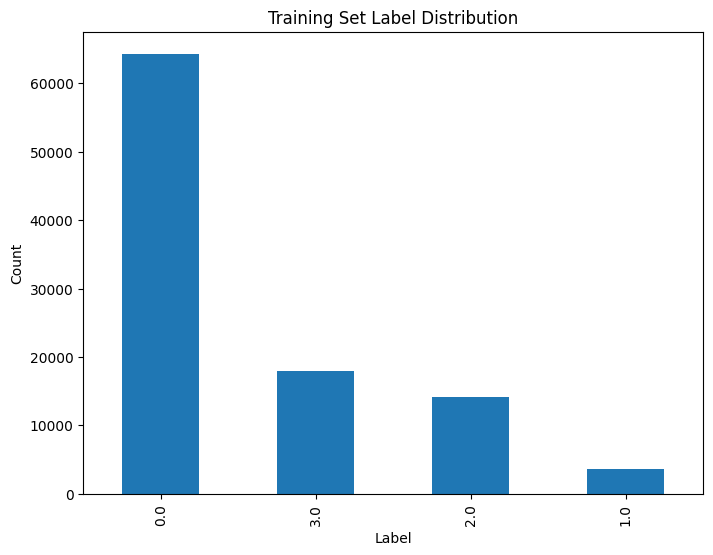

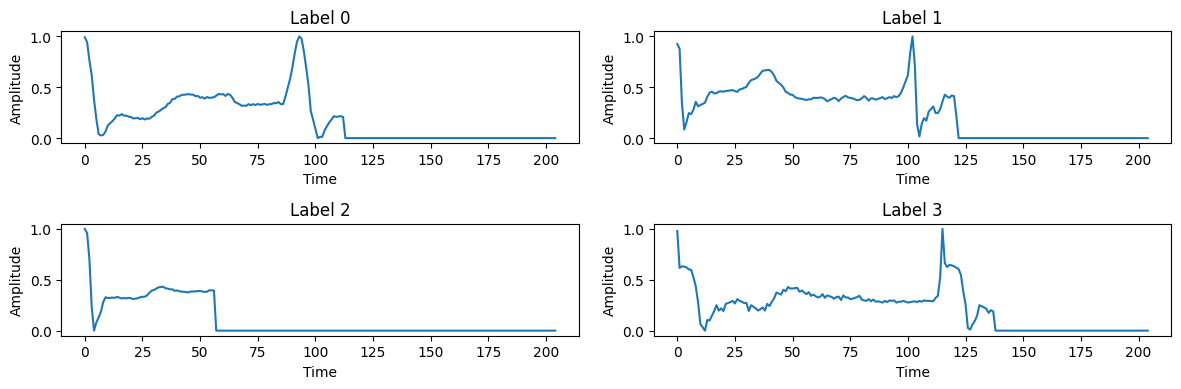

In [3]:
# 绘制训练集标签分布条形图
plt.figure(figsize=(8, 6))
train_data['label'].value_counts().plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Training Set Label Distribution')
plt.show()

# 绘制心跳信号波形图
plt.figure(figsize=(12, 4))
for i in range(4):
    signal = train_data[train_data['label'] == i]['heartbeat_signals'].values[0]
    signal = np.array(signal.split(','), dtype=np.float32)
    plt.subplot(2, 2, i+1)
    plt.plot(signal)
    plt.title(f'Label {i}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

In [4]:
# 数据预处理
class HeartbeatDataset(Dataset):
    def __init__(self, data, mode='train'):
        self.data = data
        self.mode = mode

        if self.mode == 'train':
            self.labels = data['label'].values
            self.encoder = LabelEncoder()
            self.labels = self.encoder.fit_transform(self.labels)

        self.signals = data['heartbeat_signals'].apply(lambda x: np.array(x.split(','), dtype=np.float32))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.signals.iloc[idx]

        if self.mode == 'train':
            label = self.labels[idx]
            return torch.tensor(signal, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
        else:
            return torch.tensor(signal, dtype=torch.float32)

# 创建数据集和数据加载器
train_dataset = HeartbeatDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [5]:
# 定义CNN模型
class HeartbeatClassifier(nn.Module):
    def __init__(self):
        super(HeartbeatClassifier, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(256 * 25, 512)
        self.fc2 = nn.Linear(512, 4)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
# 训练模型
model = HeartbeatClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for signals, labels in train_loader:
        signals, labels = signals.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(signals)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [1/100], Loss: 0.1632
Epoch [2/100], Loss: 0.0665
Epoch [3/100], Loss: 0.0461
Epoch [4/100], Loss: 0.0348
Epoch [5/100], Loss: 0.0266
Epoch [6/100], Loss: 0.0214
Epoch [7/100], Loss: 0.0179
Epoch [8/100], Loss: 0.0141
Epoch [9/100], Loss: 0.0119
Epoch [10/100], Loss: 0.0100
Epoch [11/100], Loss: 0.0091
Epoch [12/100], Loss: 0.0094
Epoch [13/100], Loss: 0.0070
Epoch [14/100], Loss: 0.0056
Epoch [15/100], Loss: 0.0068
Epoch [16/100], Loss: 0.0053
Epoch [17/100], Loss: 0.0057
Epoch [18/100], Loss: 0.0055
Epoch [19/100], Loss: 0.0042
Epoch [20/100], Loss: 0.0044
Epoch [21/100], Loss: 0.0053
Epoch [22/100], Loss: 0.0031
Epoch [23/100], Loss: 0.0040
Epoch [24/100], Loss: 0.0044
Epoch [25/100], Loss: 0.0032
Epoch [26/100], Loss: 0.0030
Epoch [27/100], Loss: 0.0043
Epoch [28/100], Loss: 0.0023
Epoch [29/100], Loss: 0.0040
Epoch [30/100], Loss: 0.0038
Epoch [31/100], Loss: 0.0017
Epoch [32/100], Loss: 0.0040
Epoch [33/100], Loss: 0.0019
Epoch [34/100], Loss: 0.0027
Epoch [35/100], Loss: 0

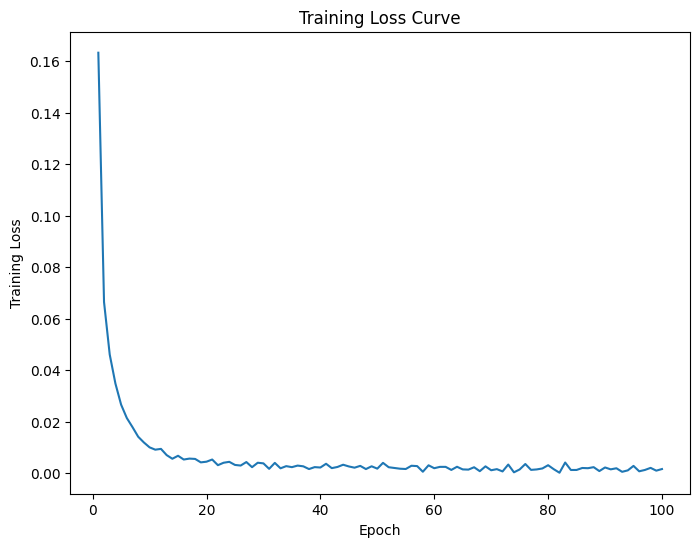

In [7]:
# 绘制训练损失曲线
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.show()

In [8]:
# 预测和提交结果
test_dataset = HeartbeatDataset(test_data, mode='test')
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()
predictions = []

with torch.no_grad():
    for signals in test_loader:
        signals = signals.to(device)
        outputs = model(signals)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
        predictions.extend(probs)

submission = pd.DataFrame({
    'id': test_data['id'],
    'label_0': [pred[0] for pred in predictions],
    'label_1': [pred[1] for pred in predictions],
    'label_2': [pred[2] for pred in predictions],
    'label_3': [pred[3] for pred in predictions]
})

submission.to_csv('/content/drive/MyDrive/Colab Notebooks/results/submission.csv', index=False, mode='w')